<b style="font-size:2vw"> Introduction</b>

1. In this notebook, a custom pipeline transformers (Custom_Pipeline_Transformer) was created and saved as a user defined library which we later imported and used it for better appeal of the code. 
2. This user defined transformer library can be used for any implementation of the below imported functions.
3. We also improved the performance of our algorithms using ensemble techniques.


<b style="font-size:2vw"> Import Library </b>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier
from Custom_Pipeline_Transformer.Custom_Pipeline_Transformer import make_column_transformerz, columnseparater, standardscaler, categorical_data, DFFeatureUnion
%matplotlib inline

<b style="font-size:2vw"> Exploratory Data Analysis </b>

In [24]:
df_train = pd.read_csv(r'C:\Users\jpravijo\Desktop\Anaconda\titanic\train.csv')
df_test = pd.read_csv(r'C:\Users\jpravijo\Desktop\Anaconda\titanic\test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This function is to create more features


In [25]:
def titanic_pre(df):
    df['Family_group'] = pd.cut(
        df.SibSp, bins=[-1, 2, 4, 10], labels=['Small', 'Medium', 'Large'])
    df['Parent_Count'] = pd.cut(
        df.Parch, bins=[-1, 0.5, 1.5, 10], labels=['No_parent', 'single_parent', 'big_family'])
    df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)
    for i in range(1, 4):
        df.Fare[df.Pclass.eq(i)] = df.Fare[df.Pclass.eq(i)].replace(
            0, df.Fare[df.Pclass.eq(i)].mean())
    df.Name = df.Name.apply(lambda x: (x.split(',')[1]).split(' ')[1])
    return df


df_train = titanic_pre(df_train)
df_test = titanic_pre(df_test)

C:\Users\jpravijo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [26]:
X_train = df_train.drop('Survived', axis=1)
y_train = df_train.pop('Survived')
X_test = df_test.drop(index=414)

In [27]:
num = ['Age', 'Fare']
cat = ['Pclass', 'Name', 'Embarked', 'Family_group', 'Parent_Count']

<b> Simple Pipeline for EDA </b>

In [28]:
pipeline = make_pipeline(
    make_pipeline(
        make_column_transformerz(SimpleImputer(
            strategy='most_frequent'), ['Embarked']),
        make_column_transformerz(SimpleImputer(
            strategy='most_frequent'), ['Fare']),
        make_column_transformerz(SimpleImputer(
            strategy='most_frequent'), ['Age']),
        make_column_transformerz(FunctionTransformer(np.log), ['Fare']),
    ),
    DFFeatureUnion([
        make_pipeline(
            columnseparater(num),
            standardscaler()
        ),
        make_pipeline(
            columnseparater(cat),
            categorical_data()
        )
    ])
)

X_train = pipeline.fit_transform(X_train)
X_train.head()

,Age,Fare,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
0,-0.497793,-1.037291,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.715048,1.407298,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.194583,-0.942080,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.487640,1.092336,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.487640,-0.925342,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [29]:
X_test = pipeline.transform(X_test)
X_test.head()

,Age,Fare,0,1,2,3,4,5,6,7,...,19,20,21,22,23,24,25,26,27,28
0,0.449739,-0.955088,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.397271,-1.074822,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2.534310,-0.727303,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.118780,-0.846912,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.497793,-0.473026,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<b style="font-size:1vw"> PCA </b>

Hardcoding the PCA

In [30]:
''' 
def pca_function(X, k=2):
  sigma = np.dot(X.T, X)/X.shape[0]
  U, S, V = np.linalg.svd(sigma)
  u_reduce=U[:, :k]
  Z = np.dot(X, u_reduce)
  return Z, S, V
Z, S, V= pca_function(x_train, k=2)

figure, ax = plt.subplots(1,1, figsize=(8,6))
ax1=plt.scatter(Z[:, 1], Z[:,0])
'''

' \ndef pca_function(X, k=2):\n  sigma = np.dot(X.T, X)/X.shape[0]\n  U, S, V = np.linalg.svd(sigma)\n  u_reduce=U[:, :k]\n  Z = np.dot(X, u_reduce)\n  return Z, S, V\nZ, S, V= pca_function(x_train, k=2)\n\nfigure, ax = plt.subplots(1,1, figsize=(8,6))\nax1=plt.scatter(Z[:, 1], Z[:,0])\n'

Sklearn PCA Function

In [31]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [32]:
print(pca.singular_values_)
# print(sum(pca.explained_variance_))

[35.41610448 30.15973032]


In [33]:
print(pca.transform(X_train))

[[-1.32251817  0.28606071]
 [ 1.98241138 -0.13349767]
 [-1.02745453  0.10607361]
 ...
 [-0.11546436 -0.84862418]
 [ 0.68925243 -0.24728835]
 [-0.92878967  0.82197548]]


Text(0, 0.5, 'principle component 2')

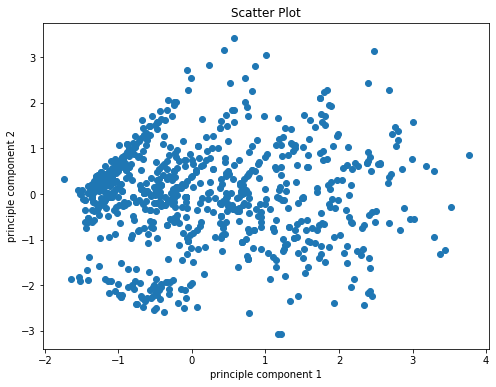

In [34]:
trans_df1 = pca.transform(X_train)
# inverse=pca.inverse_transform(trans_df1)
figure, ax = plt.subplots(1, 1, figsize=(8, 6))
ax1 = plt.scatter(trans_df1[:, 0], trans_df1[:, 1])
plt.title("Scatter Plot")
plt.xlabel("principle component 1")
plt.ylabel("principle component 2")

**Conclusion from PCA:** 
    we explored the possibility of feature distribution using PCA but since there was not much distinct distribution across features, we decided not to use feature selection.

<b style="font-size:1vw"> Learning Curve </b>

In [35]:
def learn_curve(estimator, X, y, train_sizes, cv=3, scoring='f1'):
    X_size, X_train_score, X_valid_score = learning_curve(
        estimator=estimator, X=X, y=y, train_sizes=train_sizes, cv=3, scoring='f1')
    X_train_score = X_train_score.mean(axis=1)
    X_valid_score = X_valid_score.mean(axis=1)
    return X_size, X_train_score, X_valid_score

In [36]:
train_sizes = [50, 70, 90, 100, 120, 150, 200, 210, 220, 240, 260,
               300, 320, 350, 375,  400, 425, 450, 475, 500, 510, 525, 550]
estimator = LogisticRegression(C=0.09, max_iter=5000)
X_size, X_train_score, X_valid_score = learn_curve(
    estimator, X_train, y_train, train_sizes)

Text(0.5, 1.0, 'Curve comparision')

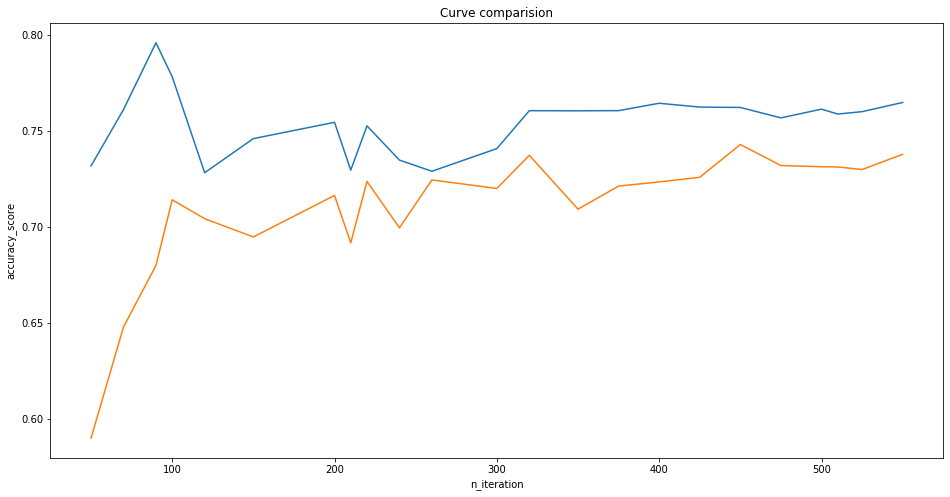

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(X_size, X_train_score)
ax.plot(X_size, X_valid_score)
plt.xlabel("n_iteration")
plt.ylabel("accuracy_score")
plt.title("Curve comparision")

<b style="font-size:1vw"> GridSearchCV </b>

In [38]:
def gridsearcher(estimator, parameters, X, y):
    clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=10)
    clf.fit(X, y)
    return clf.best_params_, clf.best_estimator_, clf.cv_results_, clf.best_score_

In [39]:
all_estimator = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier()
]
all_parameters = [
    {'C': [0.01, 0.1, 0.3, 0.5, 1, 10, 100],
        'solver':['newton-cg', 'liblinear']},
    {'C': [0.1, 1, 10, 20, 30, 100], 'kernel':['linear', 'rbf']},
    {'n_neighbors': [25, 50, 75, 100, 125, 150],
     'metric':['minkowski', 'euclidean']}
]
for estimator, parameters in zip(all_estimator, all_parameters):
    best_params, best_estimator, score, best_score = gridsearcher(
        estimator, parameters, X_train, y_train)
    print(
        f' Best Parameters = {best_params}, \n Best Estimator = {best_estimator}, \n Best_score= {best_score} \n')
    # for mean_score, params in zip(score['mean_test_score'], score['params']):
    #print(mean_score, params)

 Best Parameters = {'C': 0.1, 'solver': 'newton-cg'}, 
 Best Estimator = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False), 
 Best_score= 0.823832709113608 

 Best Parameters = {'C': 1, 'kernel': 'rbf'}, 
 Best Estimator = SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 
 Best_score= 0.823832709113608 

 Best Parameters = {'metric': 'minkowski', 'n_neighbors': 25}, 
 Best Estimator = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_nei

<b style="font-size:1vw"> Splitting the data into train and test data </b>

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

<b style="font-size:2vw"> ML Algorithms </b>

<b > Logistic Regression </b>

In [41]:
lr = LogisticRegression(
    C=0.1, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
    warm_start=False
)

lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
print('Train Accuracy = ' + str(lr.score(X_train, y_train)))
print('Test Accuracy = ' + str(lr.score(X_test, y_test)))

Train Accuracy = 0.8300561797752809
Test Accuracy = 0.8156424581005587


In [43]:
pre = lr.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.7625899280575539
Roc_Area under the curve =0.8001405212059274


<b > SVM </b>

In [44]:
svm = SVC(
    C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False
)
svm.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
print('Train Accuracy = ' + str(svm.score(X_train, y_train)))
print('Test Accuracy = ' + str(svm.score(X_test, y_test)))

Train Accuracy = 0.8455056179775281
Test Accuracy = 0.8324022346368715


In [46]:
pre = svm.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.7761194029850746
Roc_Area under the curve =0.8129790495656617


<b > Decision Tree </b>

In [47]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [48]:
print('Train Accuracy = ' + str(dtc.score(X_train, y_train)))
print('Test Accuracy = ' + str(dtc.score(X_test, y_test)))

Train Accuracy = 0.8806179775280899
Test Accuracy = 0.8435754189944135


In [49]:
pre = dtc.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.7999999999999999
Roc_Area under the curve =0.8295861011752683


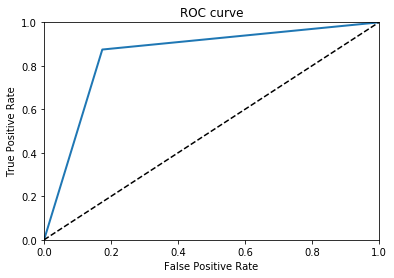

In [50]:
fpr, tpr, thresholds = roc_curve(pre, y_test)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(fpr, tpr)
plt.show()

<b style="font-size:2vw"> Ensemble ML Technique </b>

<b > voting classifier:  </b> 
Hard Voting

In [51]:
clf1 = LogisticRegression(
    C=0.5, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
    warm_start=False
)
clf2 = SVC(
    C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False
)
clf3 = DecisionTreeClassifier(
    max_depth=10, min_samples_leaf=5
)
clf4 = KNeighborsClassifier(
    algorithm='auto', leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=None, n_neighbors=25, p=2,
    weights='uniform'
)
vc = VotingClassifier(estimators=[
    ('lr', clf1), ('SVC', clf2), ('dtc', clf3), ('KNC', clf4)
], voting='hard')

In [52]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.5, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('SVC',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0....
                                                     min_impurity_split=None,
                                

In [53]:
print('Train Accuracy = ' + str(vc.score(X_train, y_train)))
print('Test Accuracy = ' + str(vc.score(X_test, y_test)))

Train Accuracy = 0.8553370786516854
Test Accuracy = 0.8435754189944135


In [54]:
pre = vc.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.7878787878787878
Roc_Area under the curve =0.8226877874297394


Soft Voting

In [55]:
clf1 = LogisticRegression(
    C=0.5, class_weight=None, dual=False, fit_intercept=True,
    intercept_scaling=1, l1_ratio=None, max_iter=100,
    multi_class='auto', n_jobs=None, penalty='l2',
    random_state=None, solver='liblinear', tol=0.0001, verbose=0,
    warm_start=False
)
clf2 = DecisionTreeClassifier(
    max_depth=10, min_samples_leaf=5
)

vc = VotingClassifier(estimators=[
    ('lr', clf1), ('DTC', clf2)
], voting='soft')

In [56]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.5, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('DTC',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                      

In [57]:
print('Train Accuracy = ' + str(vc.score(X_train, y_train)))
print('Test Accuracy = ' + str(vc.score(X_test, y_test)))

Train Accuracy = 0.8778089887640449
Test Accuracy = 0.8603351955307262


In [58]:
pre = vc.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.822695035460993
Roc_Area under the curve =0.8475983648441492


<b> Random Forest </b>

In [59]:
rf = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_depth=25, min_samples_split=2, min_samples_leaf=1,
    min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=100, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, random_state=None, verbose=0,
    warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None
)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
print('Train Accuracy = ' + str(rf.score(X_train, y_train)))
print('Test Accuracy = ' + str(rf.score(X_test, y_test)))

Train Accuracy = 0.9438202247191011
Test Accuracy = 0.8435754189944135


In [61]:
pre = rf.predict(X_test)
print('F1 score = ' + str(f1_score(y_test, pre)))
print('Roc_Area under the curve =' + str(roc_auc_score(y_test, pre)))

F1 score = 0.7971014492753624
Roc_Area under the curve =0.8278615227388861


<b> Bagging Classifier </b>

In [62]:
bcf = BaggingClassifier(
    base_estimator=SVC(), n_estimators=100, max_samples=0.6, max_features=0.8
)
bcf.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='rbf', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=0.8,
                  max_samples=0.6, n_estimators=100, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [63]:
print('Train Accuracy = ' + str(bcf.score(X_train, y_train)))
print('Test Accuracy = ' + str(bcf.score(X_test, y_test)))

Train Accuracy = 0.8356741573033708
Test Accuracy = 0.8379888268156425


In [64]:
pre = bcf.predict(X_test)
print('Accuracy = ' + str(accuracy_score(y_test, pre)))

Accuracy = 0.8379888268156425


<b style="font-size:2vw"> Conclusion </b>

1. we have successfully implemented various learning algorithms using pipeline architecture for the titanic dataset. And also, the custom pipeline transformer can be used for any upcoming project.
2. Also, we were able to obtain extra improvement in accuracy using the ensemble techniques.